<a href="https://colab.research.google.com/github/mehmetMRE/Artificial-neural-networks/blob/main/LSTM_ipynb_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , LSTM,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping


import warnings

warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [ ]:
df=pd.read_csv("/TSLA.csv")

FileNotFoundError: ignored

In [ ]:
df.head()

In [ ]:
def check_df(dataframe,head=5):
  print("########### shape ###########")
  print(dataframe.shape)
  print("########### types ###########")
  print(dataframe.dtypes)
  print("########### types ###########")
  print(dataframe.head(head))
  print("########### types ###########")
  print(dataframe.tail(head))
  print("########### types ###########")
  print(dataframe.isnull().sum())
  print("########### types ###########")
  print(dataframe.quantile([0,0.05,0.50,0.95,0.99,0.1]).T)

In [ ]:
check_df(df)

In [ ]:

df["Date"]=pd.to_datetime(df["Date"])


In [ ]:
tesla_df=df[["Date","Close"]]
tesla_df["Date"]=pd.to_datetime(tesla_df["Date"])

In [ ]:
tesla_df.head()

In [ ]:
tesla_df.index=tesla_df["Date"]
tesla_df

In [ ]:
tesla_df.drop("Date", axis=1, inplace=True)

In [ ]:
result_df=tesla_df.copy()
plt.figure(figsize=(12,6))

plt.plot(tesla_df['Close'], color='blue')
plt.xlabel('Time',fontsize=16)
plt.ylabel('stock price',fontsize=16)
plt.title('Tesla stock price',fontsize=16)
plt.show()

In [ ]:
tesla_df=tesla_df.values
tesla_df=tesla_df.astype('float32')

In [ ]:
def split_data(dataframe,test_size):
  pos=int(round(len(dataframe)*(1-test_size)))
  train=dataframe[:pos]
  test=dataframe[pos:]
  return train,test,pos

In [ ]:
train,test,pos=split_data(tesla_df,0.20)
print(train.shape,test.shape)

In [ ]:
scaler_train=MinMaxScaler(feature_range=(0,1))
train=scaler_train.fit_transform(train)
scaler_test=MinMaxScaler(feature_range=(0,1))
test=scaler_test.fit_transform(test)

In [ ]:
def create_features(data,lookback):
  X,Y=[],[]
  for i in range(lookback,len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])

  return np.array(X),np.array(Y)
lookback=20

In [ ]:
X_train,y_train=create_features(train,lookback)
X_test,y_test=create_features(test,lookback)

In [ ]:
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)

In [ ]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

In [ ]:
model=Sequential()
model.add(LSTM(units=50,
               activation='relu',
               input_shape=(X_train.shape[1],lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))

In [ ]:
model.summary()

In [ ]:
model.compile(loss='mean_squared_error',optimizer='adam')
callbacks=[EarlyStopping(monitor='val_loss',patience=3,verbose=1,mode="min"),
           ModelCheckpoint(filepath='mymodel.h5',monitor='val_loss',mode='min',
           save_best_only=True,save_weights_only=False,verbose=1)]

In [ ]:
history=model.fit(x=X_train,
                  y=y_train,
                  epochs=150,
                  batch_size=20,
                  validation_data=(X_test,y_test),
                  callbacks=callbacks,
                  shuffle=False)

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.legend(loc='upper right')
plt.xlabel('epoch',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('eğitim ve test kayıp grafiği',fontsize=16)
plt.show()

In [ ]:
loss=model.evaluate(X_test,y_test,batch_size=20)
print("\n Test Loss: %.1f%%" % (100.0*loss))

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
train_predict=scaler_train.inverse_transform(train_predict)
test_predict=scaler_test.inverse_transform(test_predict)

In [ ]:
y_train=scaler_train.inverse_transform(y_train)
y_test=scaler_test.inverse_transform(y_test)

In [ ]:
train_rmse=np.sqrt(mean_squared_error(y_train,train_predict))
test_rmse=np.sqrt(mean_squared_error(y_test,test_predict))


In [ ]:
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

In [ ]:
train_prediction_df=result_df[lookback:pos]
train_prediction_df["Predicted"]=train_predict
train_prediction_df.head()

In [ ]:
test_prediction_df=result_df[lookback+pos:]
test_prediction_df["Predicted"]=test_predict
test_prediction_df.head()

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(result_df,label='Real Values')
plt.plot(train_prediction_df["Predicted"],color='blue', label='Train Predicted')
plt.plot(test_prediction_df["Predicted"],color='red', label='Test Predicted')
plt.title('Number of Passengers Prediction')
plt.xlabel('time')
plt.ylabel('STOCK Values')
plt.legend()
plt.show()

# ***Farklı şirketlerin verilerini sanal bellekte saklayarak değerlendirme***

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
stocks=["FROTO. IS", "DEVA.IS","ELITE.IS", "GARAN.IS", "EREGL.IS", "SISE. IS", "ARCLK.IS", "BIMAS.IS", "KORDS. IS", "SASA. IS", "VESBE.IS"]
data=yf.download (stocks, start = ("2020-02-09"), end =("2022-02-10"))

In [ ]:
stocks = ["FROTO.IS", "DEVA.IS", "GARAN.IS", "EREGL.IS", "SISE. IS", "ARCLK. IS", "BIMAS.IS", "KORDS. IS", "SASA. IS", "VESBE.IS"]
data = yf.download (stocks, start =
("2021-02-09"), end =
("2022-02-10"))["Adj Close"]

In [ ]:
print (data.shape)
print(data.info())
print(data.head())

In [ ]:
returns=data.pct_change().dropna (how="any")
returns.head()

In [ ]:
returns.plot(figsize=(12,10))

In [ ]:
mean=returns.mean()
annual_mean = returns.mean()*252
standart_dev=returns.std()
annual_sd = returns.std()*252
print (pd.DataFrame (list (zip (data.columns, mean, standart_dev, annual_mean, annual_sd)), columns=[ "Stock", "Mean", "sd","annual_mean", "annual_sd"]))

In [ ]:
cov=returns.cov()*252
plt.figure(figsize=(16, 6))
mask=np.triu(np.ones_like (cov, dtype=np.bool))


heatmap=sns.heatmap(cov, mask=mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Kovaryans Matrisi', fontdict={'fontsize' :18}, pad=12);

In [ ]:
plt.figure(figsize=(16, 6))
mask= np.triu (np.ones_like (returns.corr(), dtype=np.bool))
heatmap=sns.heatmap(returns.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title( 'Korelasyon Matrisi', fontdict={'fontsize' :18}, pad=12);

Burası yfinance ile sanal bellekte hisse fiyat history tutuyor ve rsi hesaplıyor

In [1]:
import yfinance as yf
from datetime import datetime
import pandas as pd

amzn = yf.Ticker("ELITE.IS")


end_date = datetime.now().strftime('%Y-%m-%d')
amzn_hist = amzn.history(start='2023-01-01', end=end_date)


amzn_hist.dropna(inplace=True)


def calculate_rsi(data, period=14):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

amzn_hist['RSI'] = calculate_rsi(amzn_hist)

print(amzn_hist)


ERROR:yfinance:ELITE.IS: Period '1mo' is invalid, must be one of ['1d', '5d']


Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume, RSI]
Index: []


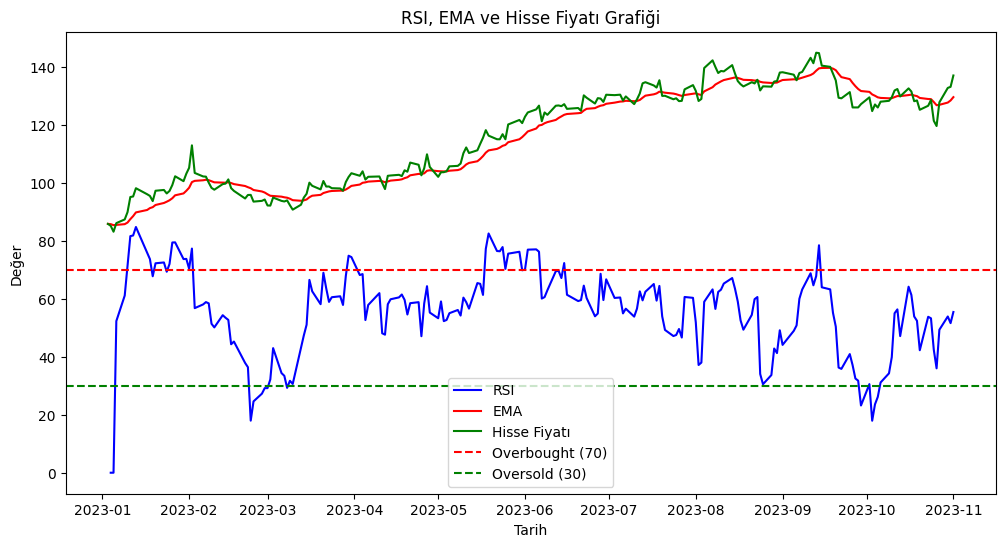

RSI Değerleri:
Date
2023-01-03 00:00:00-05:00          NaN
2023-01-04 00:00:00-05:00     0.000000
2023-01-05 00:00:00-05:00     0.000000
2023-01-06 00:00:00-05:00    52.296840
2023-01-09 00:00:00-05:00    61.095116
                               ...    
2023-10-26 00:00:00-04:00    36.002671
2023-10-27 00:00:00-04:00    49.312901
2023-10-30 00:00:00-04:00    53.883157
2023-10-31 00:00:00-04:00    51.590099
2023-11-01 00:00:00-04:00    55.426445
Name: RSI, Length: 210, dtype: float64
EMA Değerleri:
Date
2023-01-03 00:00:00-05:00     85.820000
2023-01-04 00:00:00-05:00     85.729333
2023-01-05 00:00:00-05:00     85.381422
2023-01-06 00:00:00-05:00     85.474566
2023-01-09 00:00:00-05:00     85.725957
                                ...    
2023-10-26 00:00:00-04:00    126.747847
2023-10-27 00:00:00-04:00    126.880134
2023-10-30 00:00:00-04:00    127.657450
2023-10-31 00:00:00-04:00    128.381789
2023-11-01 00:00:00-04:00    129.530884
Name: EMA, Length: 210, dtype: float64
Hisse Fiyatı 

In [10]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# AMZN hisse senedini al
amzn = yf.Ticker("AMZN")

end_date = datetime.now().strftime('%Y-%m-%d')
amzn_hist = amzn.history(start='2023-01-01', end=end_date)

amzn_hist.dropna(inplace=True)

def calculate_rsi(data, period=14):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

def calculate_ema(data, period=14):
    ema = data['Close'].ewm(span=period, adjust=False).mean()
    return ema

amzn_hist['RSI'] = calculate_rsi(amzn_hist)
amzn_hist['EMA'] = calculate_ema(amzn_hist)

# RSI, EMA ve Hisse Fiyatı grafiğini çiz
plt.figure(figsize=(12, 6))
plt.plot(amzn_hist.index, amzn_hist['RSI'], label='RSI', color='b')
plt.plot(amzn_hist.index, amzn_hist['EMA'], label='EMA', color='r')
plt.plot(amzn_hist.index, amzn_hist['Close'], label='Hisse Fiyatı', color='g')
plt.axhline(70, color='r', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='g', linestyle='--', label='Oversold (30)')
plt.title('RSI, EMA ve Hisse Fiyatı Grafiği')
plt.xlabel('Tarih')
plt.ylabel('Değer')
plt.legend()
plt.show()

# RSI, EMA ve Hisse Fiyatı değerlerini yazdır
rsi_values = amzn_hist['RSI']
ema_values = amzn_hist['EMA']
close_values = amzn_hist['Close']
print("RSI Değerleri:")
print(rsi_values)
print("EMA Değerleri:")
print(ema_values)
print("Hisse Fiyatı Değerleri:")
print(close_values)

# Veri çerçevesinin başını yazdır
print("Veri Çerçevesinin Başı:")
print(amzn_hist.head())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


Son 40 İşlem Gününün Tahmin Edilen EMA Değerleri:
2023-11-02 00:00:00-04:00    130.541427
2023-11-03 00:00:00-04:00    131.433350
2023-11-06 00:00:00-05:00    132.216992
2023-11-07 00:00:00-05:00    132.896859
2023-11-08 00:00:00-05:00    133.478536
2023-11-09 00:00:00-05:00    133.968403
2023-11-10 00:00:00-05:00    134.373388
2023-11-13 00:00:00-05:00    134.700747
2023-11-14 00:00:00-05:00    134.957884
2023-11-15 00:00:00-05:00    135.152187
Freq: B, Name: predicted_mean, dtype: float64


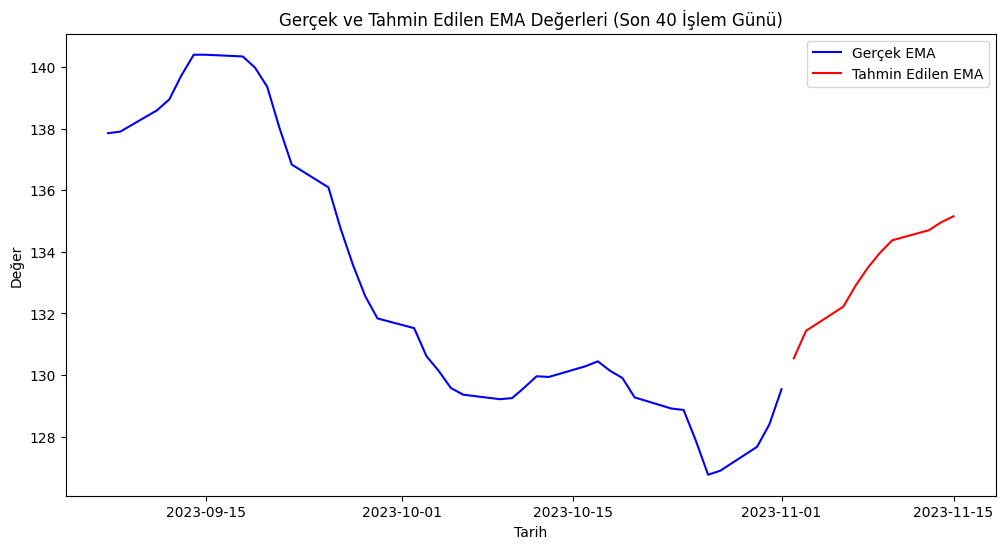

In [13]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# AMZN hisse senedini al
amzn = yf.Ticker("AMZN")

end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - pd.DateOffset(months=18)).strftime('%Y-%m-%d')
amzn_hist = amzn.history(start=start_date, end=end_date)

amzn_hist.dropna(inplace=True)

# EMA hesaplama işlevi
def calculate_ema(data, period=14):
    ema = data['Close'].ewm(span=period, adjust=False).mean()
    return ema

# Son 40 işlem gününün verilerini al
last_40_days = amzn_hist.tail(40)
last_40_days_ema = calculate_ema(last_40_days)

# ARIMA modelini kullanarak son 40 işlem gününün EMA tahminini yap
order = (2, 1, 2)  # Örnek bir ARIMA parametre seti
model = sm.tsa.ARIMA(last_40_days_ema, order=order)
results = model.fit()
forecasted_values = results.forecast(steps=10)  # 10 işlem günü için tahmin yapabilirsiniz

# Tahmin edilen EMA değerlerini yazdır
print("Son 40 İşlem Gününün Tahmin Edilen EMA Değerleri:")
print(forecasted_values)

# Gerçek EMA değerlerini ve tahminleri grafikte göster
plt.figure(figsize=(12, 6))
plt.plot(last_40_days.index, last_40_days_ema, label='Gerçek EMA', color='b')
plt.plot(forecasted_values.index, forecasted_values, label='Tahmin Edilen EMA', color='r')
plt.title('Gerçek ve Tahmin Edilen EMA Değerleri (Son 40 İşlem Günü)')
plt.xlabel('Tarih')
plt.ylabel('Değer')
plt.legend()
plt.show()


EMA (12 günlük):
[124.5, 124.46207721416766, 124.68768030651927, 123.41372913331078, 122.08430912579722, 120.03887717795823, 118.31889625206742, 116.3270663129723, 114.88144014417969, 114.60044939971755, 114.01738043031989, 114.22524494194136, 113.1309769588362, 112.23682669503688, 111.52208465241101, 110.91207150689284, 109.86406027108181, 109.38882046412752, 109.64861722189997, 110.49444528526752, 111.98906957581531, 113.48059704229144, 115.33142851069492, 116.41120850506817, 117.70025349129266, 118.51559910801686, 118.92550698450285, 118.49850614471455, 117.13719774181676, 115.06532088445192, 113.1029634497045, 112.26712263728001, 110.94295048725375, 110.21634290778442, 109.9799825073831, 109.82152319059219, 110.2243661522559, 111.18369429567386, 111.4969722841399, 110.86666909056129, 110.56718125646653, 109.89684553769824, 109.84502277168217, 110.40732696065415, 111.01081540225422, 111.82915177591583, 112.40005164354837, 112.30004369838709, 111.82619100951263, 111.60677724279975, 1

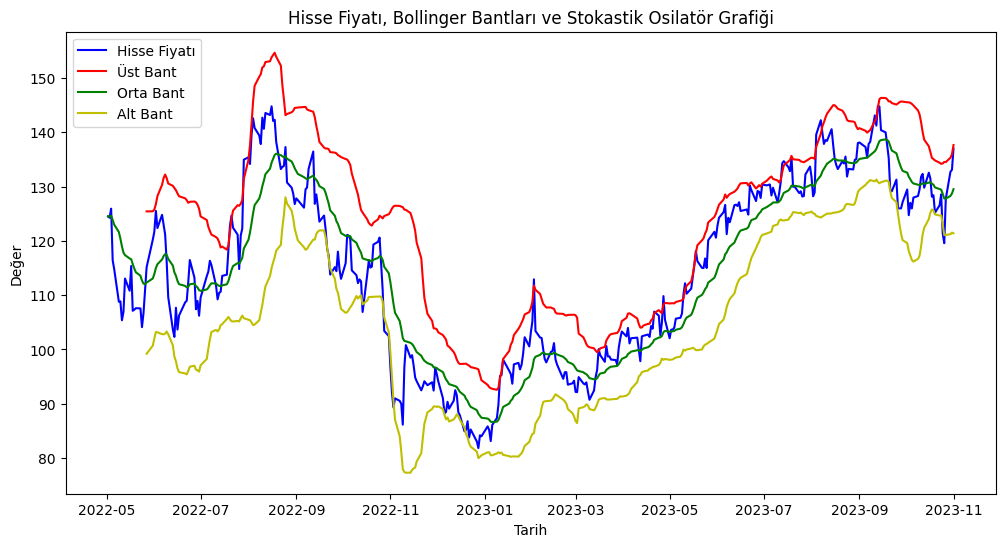

In [17]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# AMZN hisse senedini al
amzn = yf.Ticker("AMZN")

end_date = pd.Timestamp.today()
start_date = end_date - pd.DateOffset(months=18)
amzn_hist = amzn.history(start=start_date, end=end_date)

# Hissesi senedi kapanış fiyatları
close_prices = amzn_hist['Close']

# EMA (12 günlük ve 26 günlük) hesaplama
def calculate_ema(data, period):
    ema = [data[0]]
    multiplier = 2 / (period + 1)

    for i in range(1, len(data)):
        ema_value = (data[i] - ema[i-1]) * multiplier + ema[i-1]
        ema.append(ema_value)

    return ema

ema_12 = calculate_ema(close_prices, 12)
ema_26 = calculate_ema(close_prices, 26)

# RSI (14 günlük) hesaplama
def calculate_rsi(data, period):
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

rsi = calculate_rsi(close_prices, 14)

# MACD (12, 26) hesaplama
macd_line = [ema_12[i] - ema_26[i] for i in range(len(ema_12))]
signal_line = calculate_ema(macd_line, 9)

# Bollinger Bantları (20 günlük) hesaplama
def calculate_bollinger_bands(data, period, num_std_dev=2):
    middle_band = calculate_ema(data, period)
    rolling_std = data.rolling(window=period).std()
    upper_band = middle_band + num_std_dev * rolling_std
    lower_band = middle_band - num_std_dev * rolling_std
    return upper_band, middle_band, lower_band

upper_band, middle_band, lower_band = calculate_bollinger_bands(close_prices, 20)

# Stokastik Osilatör hesaplama
def calculate_stochastic_oscillator(data, fastk_period, slowk_period, slowd_period):
    low_min = data.rolling(window=fastk_period).min()
    high_max = data.rolling(window=fastk_period).max()
    fastk = (data - low_min) / (high_max - low_min) * 100
    slowk = fastk.rolling(window=slowk_period).mean()
    slowd = slowk.rolling(window=slowd_period).mean()
    return slowk, slowd

slowk, slowd = calculate_stochastic_oscillator(close_prices, 14, 3, 3)

# Sonuçları yazdır
print("EMA (12 günlük):")
print(ema_12)
print("\nEMA (26 günlük):")
print(ema_26)
print("\nRSI (14 günlük):")
print(rsi)
print("\nMACD Hattı:")
print(macd_line)
print("Signal Hattı:")
print(signal_line)
print("\nBollinger Bantları - Üst Bant:")
print(upper_band)
print("Bollinger Bantları - Orta Bant:")
print(middle_band)
print("Bollinger Bantları - Alt Bant:")
print(lower_band)
print("\nStokastik Osilatör - Stokastik K:")
print(slowk)
print("Stokastik Osilatör - Stokastik D:")
print(slowd)

# Grafiği çizdir
plt.figure(figsize=(12, 6))
plt.plot(amzn_hist.index, close_prices, label='Hisse Fiyatı', color='b')
plt.plot(amzn_hist.index, upper_band, label='Üst Bant', color='r')
plt.plot(amzn_hist.index, middle_band, label='Orta Bant', color='g')
plt.plot(amzn_hist.index, lower_band, label='Alt Bant', color='y')
plt.title('Hisse Fiyatı, Bollinger Bantları ve Stokastik Osilatör Grafiği')
plt.xlabel('Tarih')
plt.ylabel('Değer')
plt.legend()
plt.show()


# EMA (Exponential Moving Average): Hissesi senedi fiyatının EMA'sını hesaplayabilirsiniz. EMA, hisse senedinin hareketli ortalamasını temsil eder. Önceki yanıtta verilen EMA hesaplama işlevini kullanabilirsiniz.
--------------------------------------------------------------
# RSI (Relative Strength Index): Hissesi senedinin RSI'sini hesaplayabilirsiniz. RSI, bir hisse senedinin aşırı alım veya aşırı satım koşullarını değerlendirmeye yardımcı olur. Daha önce verdiğiniz RSI hesaplama işlevini kullanabilirsiniz.
---------------------------------

# MACD (Moving Average Convergence Divergence): MACD, iki farklı EMA (genellikle 12 günlük ve 26 günlük) arasındaki farkı ölçer. MACD histogramı ve sinyal hattı gibi ek göstergeleri içerir.
-------------------------------
# Bollinger Bantları: Bollinger Bantları, bir hisse senedinin volatilitesini ölçer ve fiyatların olası sınırlarını gösterir. Üst bant, alt bant ve merkezi bant gibi bileşenleri vardır.
--------------------------------
# Stokastik Osilatör: Stokastik osilatör, bir hisse senedinin mevcut kapanış fiyatının, belirli bir dönem içindeki en yüksek ve en düşük fiyatlarının nerede olduğunu gösteren bir göstergedir.